# Importing Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from pycomp.viz.insights import *
from sklearn.preprocessing import QuantileTransformer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from statistics import median
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')


In [2]:
cd Downloads

/Users/karampruthi/Downloads


# Read the dataset

In [3]:
train_set = pd.read_csv('CE802_P3_Data.csv')    # creating a dataframe for training data
test_set = pd.read_csv('CE802_P3_Test.csv')     # creating a dataframe for testing data
df = train_set

In [4]:
df = pd.get_dummies(df, columns= ['F4'])                                        # OneHotEncoding
cleanup = {'F12': {'Very low': 0, 'Low':1, 'Medium':2,'High':3,'Very high':4}}  # Mapping Ordinal values 
df.replace(cleanup, inplace=True)
df

,F1,F2,F3,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,Target,F4_Europe,F4_Rest,F4_UK,F4_USA
0,16.56,12.42,-236.06,-98.88,529.56,4.54,379.54,1,1,7.30,3,-15085.87,-12.93,-39.42,1734.58,3616.82,0,1,0,0
1,11.72,12.46,-190.06,-59.22,493.11,0.05,402.78,5,3,-1.28,0,-15782.44,-8.55,-35.61,1672.70,3342.88,0,1,0,0
2,4.34,2.74,-201.20,-228.48,563.79,1.22,147.35,4,4,8.28,1,-10526.01,-9.66,-29.10,1462.86,0.00,0,0,1,0
3,12.76,2.58,-282.26,-173.28,536.94,0.25,113.49,4,3,6.26,1,-8327.14,-19.23,-34.59,809.46,1742.65,0,0,1,0
4,11.10,9.82,-242.86,-193.14,617.52,9.15,343.64,8,6,-6.88,0,-14434.13,-9.45,-46.14,1435.90,373.56,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,5.20,4.70,-218.72,-224.04,539.91,8.23,-232.93,2,3,12.32,4,-16977.67,5.01,-29.67,1420.16,1515.56,0,1,0,0
1496,12.10,2.98,-144.42,-76.05,736.65,0.48,90.41,3,6,7.40,2,-13927.89,0.66,-36.06,1321.82,1528.48,0,0,1,0
1497,4.12,4.36,-160.30,-230.43,439.86,0.69,-224.44,3,3,7.02,2,-18373.26,-7.68,-39.42,1905.86,323.67,1,0,0,0
1498,1.58,13.50,-159.60,-233.85,572.58,0.29,-126.79,1,5,1.68,4,-22863.72,-3.12,-54.36,2424.42,109.19,0,0,0,1


# Data visualization


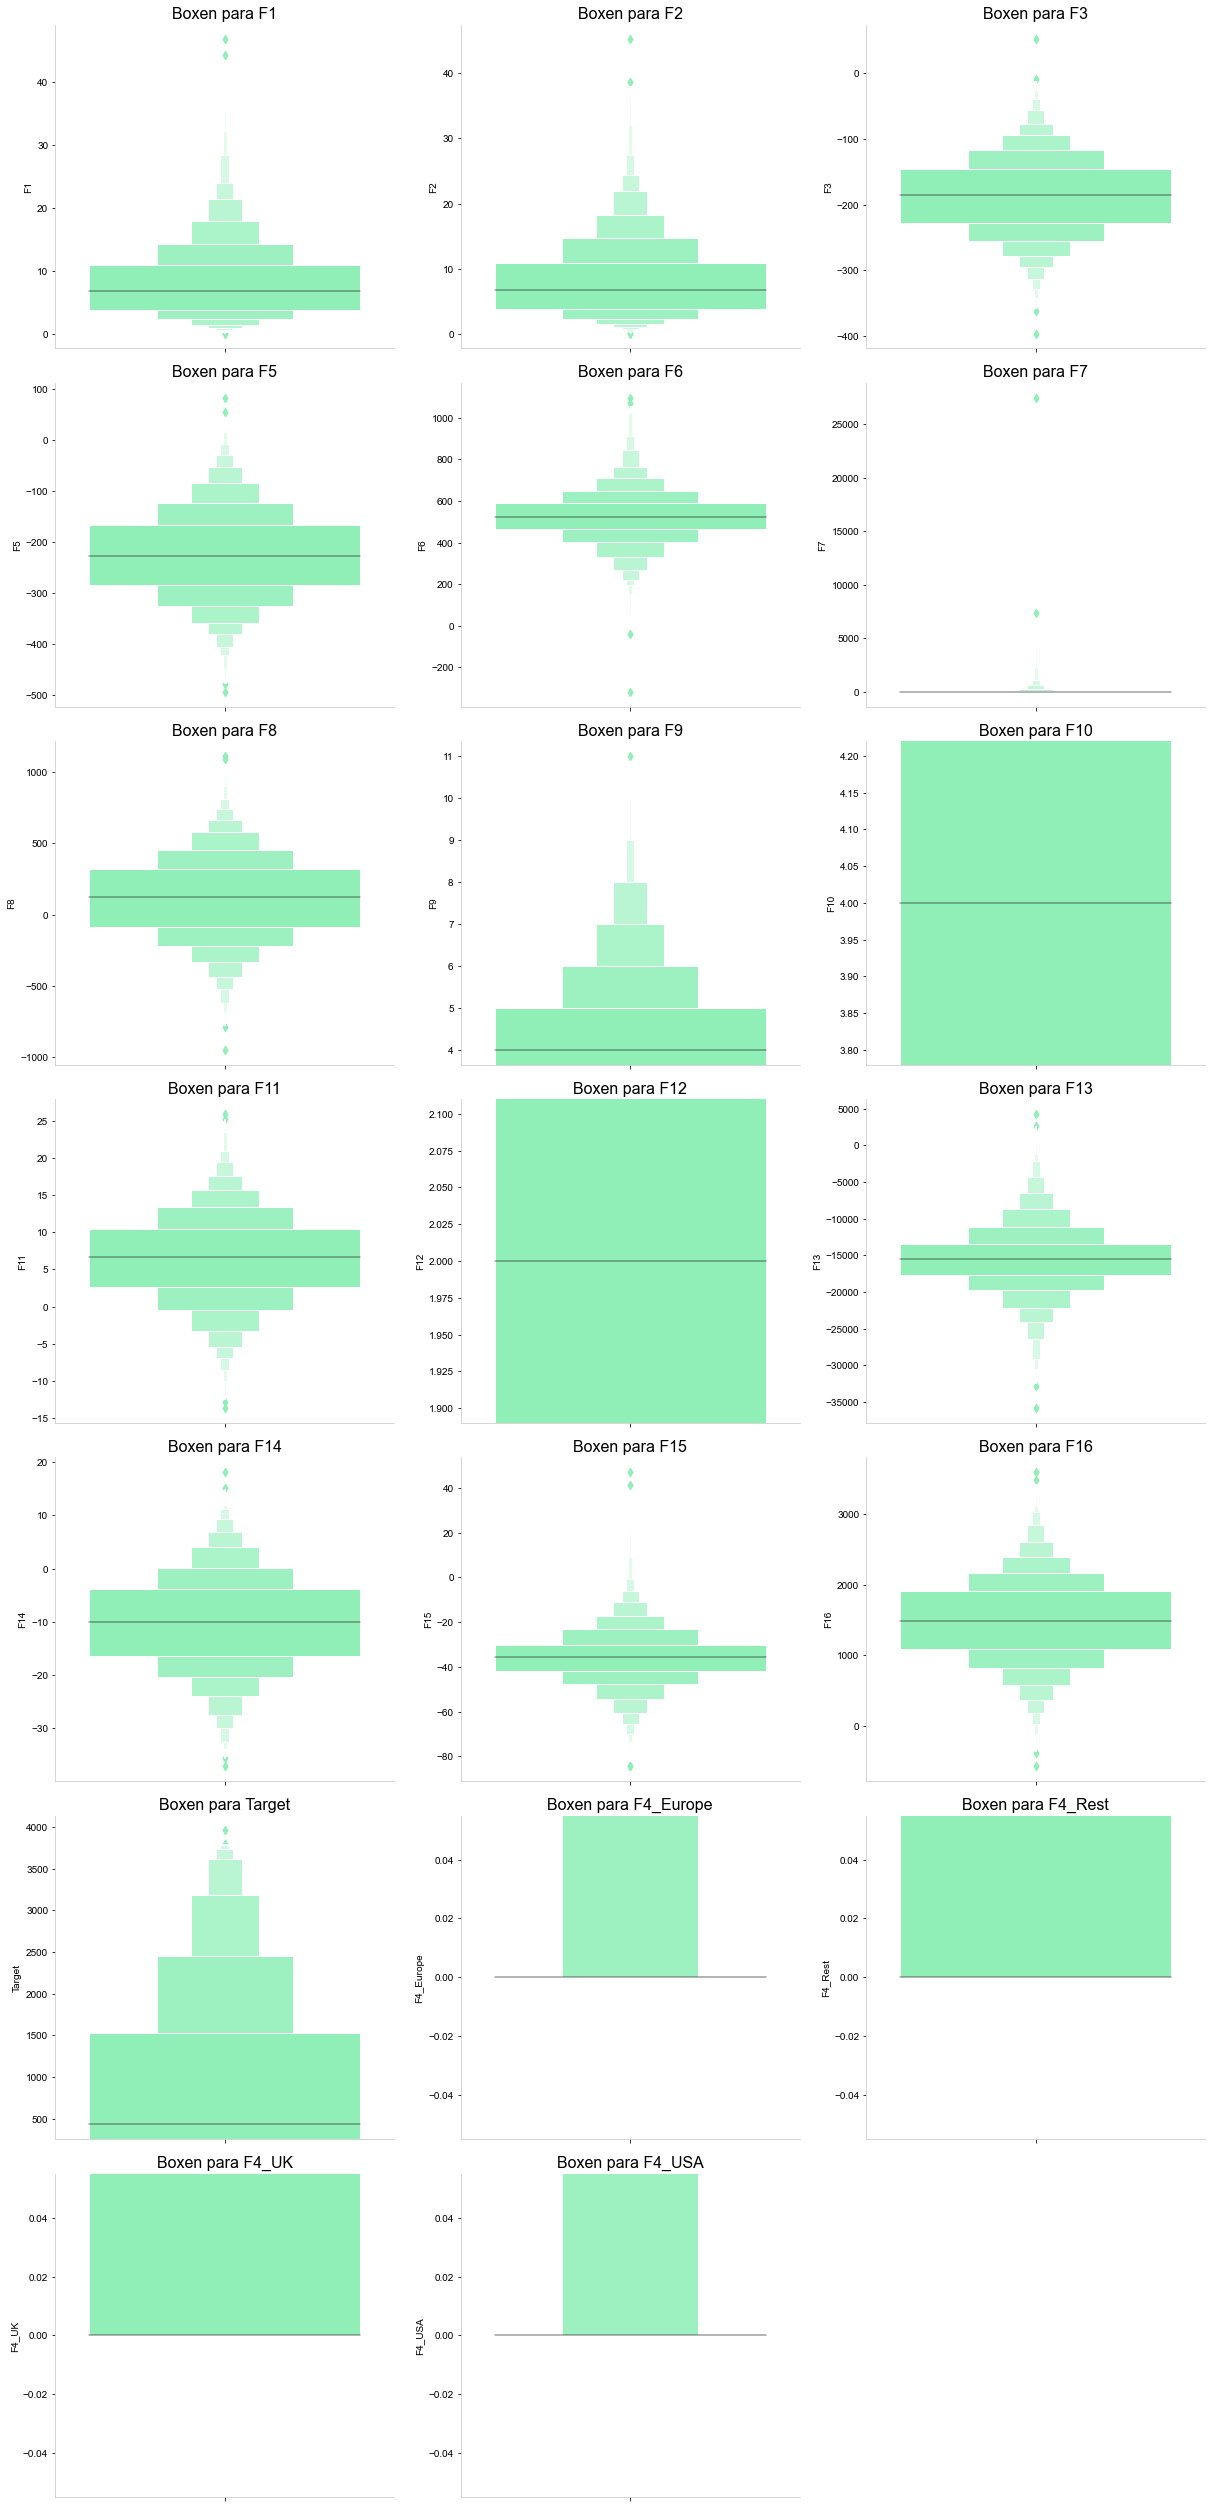

In [5]:
plot_multiple_distplots(df=df, col_list=df.columns, kind='boxen')  # plotting boxplot

# Heatmap for correlation

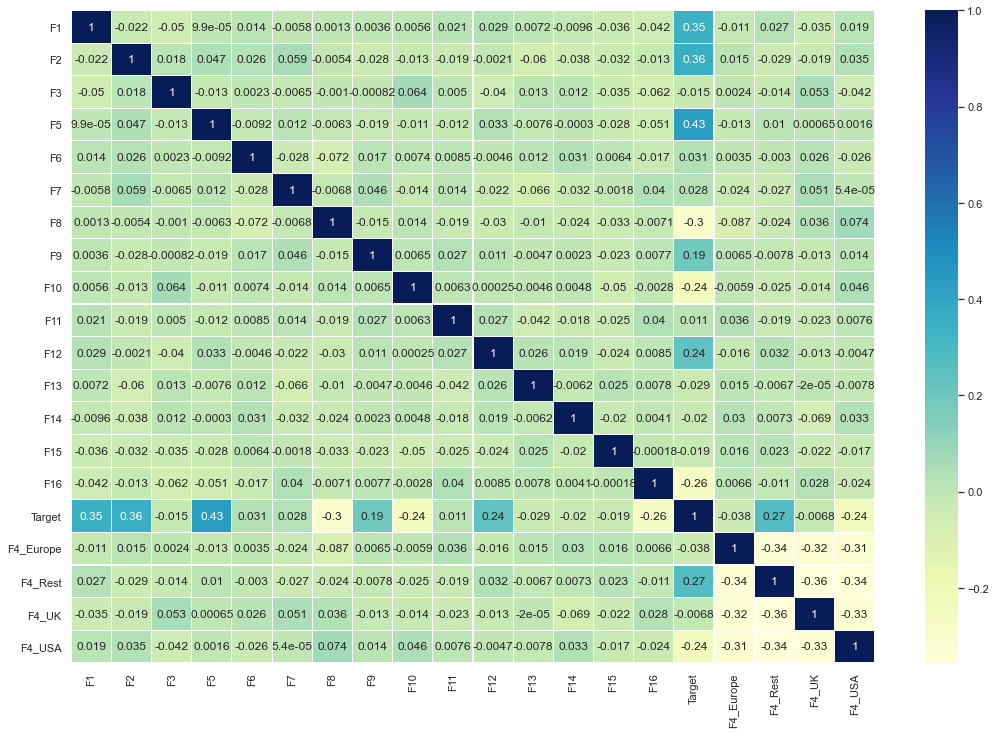

In [6]:
corrmat = df.corr() 
  
f, ax = plt.subplots(figsize =(18, 12))           # Plotting Heatmap
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1,annot=True)

In [7]:
# CLASS TO HANDLE OUTLIERS IN THE DATA WITH QUANTILE RANGE

class ThressholdScaler(BaseEstimator, TransformerMixin):
    
    """ Summary: ->detecting and removing outliers from the dataframe
                 ->the rows which are outside the quantile range will be removed 
        Parameters: dataframe
  
        Returns: the dataframe after removing the outliers """
   
    def __init__(self, offset=1.5):
        
        """ Summary: setting paramters and iqr range
        Parameters: IQR Range """
        
        self.offset = offset
        self.outlier_columns = []
        self.min = {}
        self.max = {}

    def fit(self, X, y=None):
        """ Summary: setting lower and higher limit to detect outliers outside the range
        
        Parameters: dataframe
  
        Returns: object """
    
        X = pd.DataFrame(X, columns=df.columns)
        for col_name in X.columns:
            Q1 = X[col_name].quantile(0.10)
            Q3 = X[col_name].quantile(0.80)
            IQR = Q3-Q1
            self.min[col_name] = Q1 - self.offset*IQR
            self.max[col_name] = Q3 + self.offset*IQR
            if (len(X[( X[col_name]<self.min[col_name]) | (X[col_name] > self.max[col_name])][col_name])) >= 1:
                self.outlier_columns.append(col_name) 
        return self

    def transform(self, X, y=None):
        """ Summary: removing outliers outside the quantile range
        
        Parameters: dataframe 
  
        Returns: transformed dataframe """
        
        for col_name in self.outlier_columns:
            X = X [ ( X[col_name] > self.min[col_name]) & (X[col_name] < self.max[col_name])]
        return X

    def fit_transform(self, X, y=None, **fit_params):
        
        """ Summary: fitting dataframe into fit and transform function 
        
        Parameters: dataframe
  
        Returns: transformed dataframe """
        
        self.fit(X, y)
        return self.transform(X, y)

In [8]:
# setting various paramters for grid search optimization 

model_params = {
    'svm': {
        'model': SVR(),
        'params' : {
            'C': [1,10,20,40,45],
           'kernel': ['rbf','poly']
        }  
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [100,250,500]
        }
    },
    'linear' : {
        'model': LinearRegression(),
        'params': {
            
        }
    },
    'Gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'max_depth' : range(3,6)
        }
    },
    'MLP': {
        'model': MLPRegressor(max_iter=1500,early_stopping=True),
        'params': {
            'solver' : ['lbfgs']      
        }                          
    }
}

In [9]:
# GRID SEARCH 

dict = {}                                # DICTIONARY FOR ADDING MODEL NAME AND RESULTS
def grid_search(xtrain,ytrain,xtest,ytest):
    
    """ Summary: grid search to return best models 
  
    Parameters: training and testing data after train_test_split
  
    Returns: 
    1. print table of the models with all paramters
    2. residual plot of the best_model """
    
    scores = []
    cv = RepeatedKFold(n_splits =10, n_repeats=3)
    for model_name, mp in model_params.items():
        clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
        clf.fit(xtrain,ytrain)
        cv_results = (cross_val_score(clf.best_estimator_,xtrain,ytrain,cv=10))
        predict = clf.best_estimator_.predict(xtest)
        error = (mean_squared_error(ytest,predict))**(1/2)
        
        if model_name in dict.keys():
            dict[model_name].extend(cv_results)
        else:
            dict[model_name] = list(cv_results)

        scores.append({
            'model': model_name,
            'best_params': clf.best_params_,
            'test_score' : clf.best_estimator_.score(xtest,ytest),
            'rmse' : error,
            'best_classifier' : clf.best_estimator_
            })
    # dataframe to add all the above features from the gridsearch 
    df = pd.DataFrame(scores,columns=['model','best_params','test_score','rmse','best_classifier'])
    print(df[['model','best_params','test_score','rmse']])

    best_row = df[df['test_score'] == (df.test_score.max())]    # extracting best model from the above dataframe
    best_classifier = best_row['best_classifier'].values
    
    #creating residual plot of the best model
    from yellowbrick.regressor import ResidualsPlot

    visualizer = ResidualsPlot(best_classifier[0],hist=True)

    visualizer.fit(xtrain, ytrain)  # Fit the training data to the visualizer
    visualizer.score(xtest, ytest)  # Evaluate the model on the test data
    visualizer.show()

In [10]:
def remove_out(df):
        
    """ Summary: to remove outliers with quantile range
  
    Parameters: dataframe
  
    Returns: the dataframe after removing the outliers """


    from sklearn import preprocessing
    inputs = df.copy()
    trs_scalar = ThressholdScaler()
    inputs = trs_scalar.fit_transform(df)
    inputs = pd.DataFrame(inputs,columns=df.columns)

    return inputs    

In [11]:
def log_normalize(data):
    
    """ Summary: to handle skewed values in a dataframe
  
    Parameters:dataframe
  
    Returns: the dataframe after log transformation """
    
    import numpy as np 
    data = np.log(data)
    data = pd.DataFrame(data,columns=df.columns)
    
    return data
   

          ************** MINMAX SCALER *************
               model                 best_params  test_score      rmse
0                svm  {'C': 10, 'kernel': 'rbf'}    0.844738  0.324079
1      random_forest       {'n_estimators': 500}    0.650909  0.485945
2             linear                          {}    0.817110  0.351733
3  Gradient_boosting            {'max_depth': 4}    0.795089  0.372306
4                MLP         {'solver': 'lbfgs'}    0.911729  0.244359


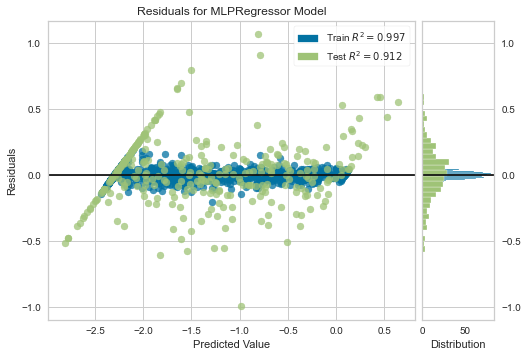

          ************** STANDARD SCALER *************
               model                 best_params  test_score      rmse
0                svm  {'C': 20, 'kernel': 'rbf'}    0.879572  0.363304
1      random_forest       {'n_estimators': 500}    0.661795  0.608830
2             linear                          {}    0.798874  0.469505
3  Gradient_boosting            {'max_depth': 4}    0.825197  0.437704
4                MLP         {'solver': 'lbfgs'}    0.983465  0.134619


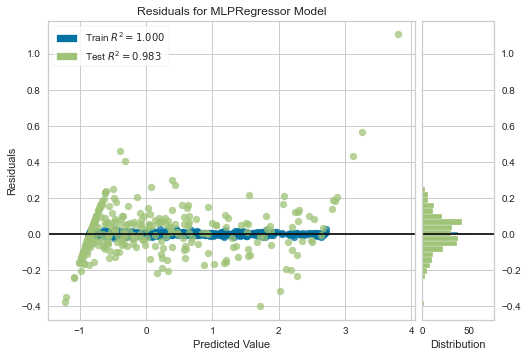

          ************** QUANTILE SCALER *************
               model                 best_params  test_score      rmse
0                svm  {'C': 20, 'kernel': 'rbf'}    0.679292  1.509955
1      random_forest       {'n_estimators': 500}    0.530731  1.826502
2             linear                          {}    0.692218  1.479214
3  Gradient_boosting            {'max_depth': 3}    0.671605  1.527943
4                MLP         {'solver': 'lbfgs'}    0.606271  1.673046


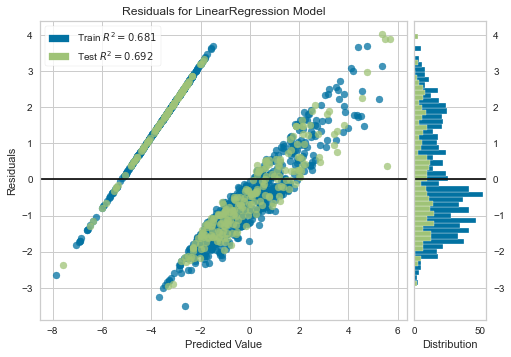

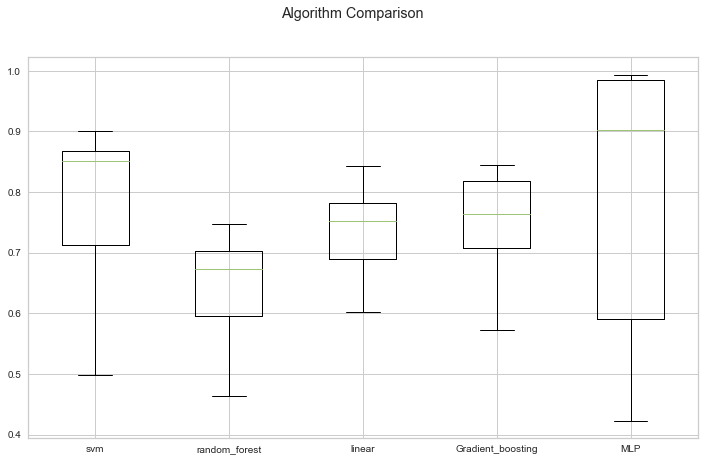

In [12]:
# Loop which takes the dataframe and implement different scaling techniques with grid search

scaling_list = ['min_max','std','quantile']
cont = True
for method in scaling_list:
    if method == 'min_max':
        inputs = df.copy()
        inputs = remove_out(inputs)
        
        scaler = preprocessing.MinMaxScaler(feature_range=(0.1,1.1))
        inputs = scaler.fit_transform(inputs.values.reshape(-1,20))
        
        inputs = log_normalize(inputs)
        
        output = inputs['Target']
        inputs = inputs.drop(['Target'],axis=1)
        x = inputs.to_numpy()
        y = output.to_numpy()



        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25,random_state=45)
        print('          ************** MINMAX SCALER *************')
        grid_search(x_train,y_train,x_test,y_test)

    elif method=='std':
        
        inputs = df.copy()
        inputs = remove_out(inputs)

        scaler = preprocessing.StandardScaler()
        inputs = scaler.fit_transform(inputs)
        inputs = pd.DataFrame(inputs)

        output = inputs[15]
        inputs = inputs.drop([15],axis=1)        

        x = inputs.to_numpy()
        y = output.to_numpy()

        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25,random_state=45)
        print('          ************** STANDARD SCALER *************')
        grid_search(x_train,y_train,x_test,y_test)
        
    elif method=='quantile':
        
        inputs = df.copy()
        inputs = remove_out(inputs)
        
        quantile = QuantileTransformer(output_distribution='normal')
        inputs = quantile.fit_transform(inputs)
        inputs = pd.DataFrame(inputs)
        
        output = inputs[15]
        inputs = inputs.drop([15],axis=1)
        
        x = inputs.to_numpy()
        y = output.to_numpy()

        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25,random_state=45)
        print('          ************** QUANTILE SCALER *************')
        grid_search(x_train,y_train,x_test,y_test)
    
    
fig = plt.figure(figsize = (12,7)) 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(dict.values()) 
ax.set_xticklabels(dict.keys())
plt.show()


# Traning & Testing on selected model

In [27]:
df1 = df.copy()

In [28]:
inputs = df1.drop('Target',axis=1)                  # spliting into inputs & target 
target = df1['Target']
target = pd.DataFrame(target)

from sklearn.preprocessing import StandardScaler    # normalizing with standard scalar
sc_in = StandardScaler()                            # making different objects for inputs and target
sc_out = StandardScaler()
inputs = sc_in.fit_transform(inputs)
target = sc_out.fit_transform(target)

x_train, x_test, y_train, y_test = train_test_split(inputs,target,test_size=0.25,random_state=9)

In [29]:
# fitting mlp regressor to the data 
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(solver='lbfgs',max_iter=2000,early_stopping=True)
mlp.fit(x_train,y_train)
mlp.score(x_test,y_test)

0.9940456054952977

In [16]:
df2 = test_set.copy()

In [17]:
# changing categorical values to numerical values in the test file
df2 = pd.get_dummies(df2, columns= ['F4'])
df2.replace(cleanup, inplace=True)
df2

,F1,F2,F3,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,Target,F4_Europe,F4_Rest,F4_UK,F4_USA
0,28.70,0.82,-115.06,-280.95,581.10,0.06,214.35,2,2,-0.88,1,-14794.01,-15.09,-35.61,1578.68,NaN,0,0,0,1
1,5.40,6.90,-170.24,-228.00,330.54,0.31,-164.98,1,9,0.28,2,-11632.88,0.72,-29.73,1647.02,NaN,0,1,0,0
2,21.96,4.40,-219.12,-59.67,662.28,4.98,281.54,6,5,5.82,1,-12631.29,-23.61,-32.73,1449.14,NaN,0,1,0,0
3,10.52,1.02,-184.14,-211.23,506.55,0.57,-311.96,7,5,1.92,3,-26664.88,1.80,-22.92,911.98,NaN,0,0,1,0
4,2.00,0.58,-190.56,-284.82,649.41,0.05,291.47,8,3,-0.02,1,-9901.41,-13.47,-48.81,2251.04,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,18.42,8.22,-213.52,-189.33,569.43,0.09,-315.11,2,3,8.64,4,-16759.93,-13.56,-37.08,869.80,NaN,0,1,0,0
1496,12.06,14.46,-251.02,-87.90,640.32,3.67,201.37,7,8,9.34,0,-11645.46,-4.35,-56.10,2040.40,NaN,0,1,0,0
1497,6.54,10.42,-156.28,-221.82,462.30,0.00,-267.50,2,6,5.00,1,-23752.87,-8.37,-21.27,1130.64,NaN,1,0,0,0
1498,8.06,13.34,-211.82,-483.24,766.38,0.19,140.38,4,6,5.34,2,-13748.25,-9.21,-18.96,1261.38,NaN,0,0,1,0


In [18]:
test_inputs = df2.drop('Target',axis=1)
test_inputs = sc_in.transform(test_inputs)

In [19]:
Target = mlp.predict(test_inputs)
test_inputs = sc_in.inverse_transform(test_inputs)
Target = sc_out.inverse_transform(Target)

In [20]:
test_set['Target'] = Target

In [21]:
test_set[test_set['Target']<0]

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,Target
1,5.40,6.90,-170.24,Rest,-228.00,330.54,0.31,-164.98,1,9,0.28,Medium,-11632.88,0.72,-29.73,1647.02,-47.899027
4,2.00,0.58,-190.56,Rest,-284.82,649.41,0.05,291.47,8,3,-0.02,Low,-9901.41,-13.47,-48.81,2251.04,-289.747045
15,3.04,3.86,-74.36,Europe,-320.85,338.61,0.10,158.43,2,1,4.64,High,-17837.77,3.03,-39.51,1922.92,-112.636619
19,1.18,2.56,-119.62,Europe,-250.23,593.79,0.04,189.39,3,2,12.88,Low,-16237.49,2.55,-38.28,562.30,-65.428175
21,4.50,7.66,-252.12,Rest,-381.06,211.53,4.12,185.79,3,8,12.14,Very high,-12584.21,4.86,-40.59,2407.18,-289.720558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,6.92,9.78,-59.20,UK,-451.83,530.97,36.77,741.27,2,4,12.04,Low,-17104.49,-12.93,-39.09,1872.60,-214.367864
1465,6.92,2.94,-239.26,Europe,-223.11,251.61,51.01,322.44,3,5,6.24,Very low,-16563.98,-12.66,-27.54,769.76,-67.999951
1470,4.78,1.10,-63.48,USA,-163.05,636.93,0.38,-194.68,4,6,5.60,Medium,-18802.76,-11.73,-60.69,2145.02,-33.690036
1498,8.06,13.34,-211.82,UK,-483.24,766.38,0.19,140.38,4,6,5.34,Medium,-13748.25,-9.21,-18.96,1261.38,-219.448173


In [22]:
# verifying the inverse_transform method 
col = ['F1', 'F2', 'F3', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12',
       'F13', 'F14', 'F15', 'F16','F4_Europe', 'F4_Rest', 'F4_UK',
       'F4_USA']
test_inputs = pd.DataFrame(test_inputs,columns=col)
test_inputs

,F1,F2,F3,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F4_Europe,F4_Rest,F4_UK,F4_USA
0,28.70,0.82,-115.06,-280.95,581.10,0.06,214.35,2.0,2.0,-0.88,1.0,-14794.01,-15.09,-35.61,1578.68,0.0,0.0,0.0,1.0
1,5.40,6.90,-170.24,-228.00,330.54,0.31,-164.98,1.0,9.0,0.28,2.0,-11632.88,0.72,-29.73,1647.02,0.0,1.0,0.0,0.0
2,21.96,4.40,-219.12,-59.67,662.28,4.98,281.54,6.0,5.0,5.82,1.0,-12631.29,-23.61,-32.73,1449.14,0.0,1.0,0.0,0.0
3,10.52,1.02,-184.14,-211.23,506.55,0.57,-311.96,7.0,5.0,1.92,3.0,-26664.88,1.80,-22.92,911.98,0.0,0.0,1.0,0.0
4,2.00,0.58,-190.56,-284.82,649.41,0.05,291.47,8.0,3.0,-0.02,1.0,-9901.41,-13.47,-48.81,2251.04,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,18.42,8.22,-213.52,-189.33,569.43,0.09,-315.11,2.0,3.0,8.64,4.0,-16759.93,-13.56,-37.08,869.80,0.0,1.0,0.0,0.0
1496,12.06,14.46,-251.02,-87.90,640.32,3.67,201.37,7.0,8.0,9.34,0.0,-11645.46,-4.35,-56.10,2040.40,0.0,1.0,0.0,0.0
1497,6.54,10.42,-156.28,-221.82,462.30,0.00,-267.50,2.0,6.0,5.00,1.0,-23752.87,-8.37,-21.27,1130.64,1.0,0.0,0.0,0.0
1498,8.06,13.34,-211.82,-483.24,766.38,0.19,140.38,4.0,6.0,5.34,2.0,-13748.25,-9.21,-18.96,1261.38,0.0,0.0,1.0,0.0


In [23]:
test_set['Target']=test_set['Target'].apply(lambda x: 0 if x<0 else x)  # changing all negative numbers to 0

In [24]:
test_set[test_set['Target']<0]

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,Target


In [25]:
test_set

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,Target
0,28.70,0.82,-115.06,USA,-280.95,581.10,0.06,214.35,2,2,-0.88,Low,-14794.01,-15.09,-35.61,1578.68,266.488561
1,5.40,6.90,-170.24,Rest,-228.00,330.54,0.31,-164.98,1,9,0.28,Medium,-11632.88,0.72,-29.73,1647.02,0.000000
2,21.96,4.40,-219.12,Rest,-59.67,662.28,4.98,281.54,6,5,5.82,Low,-12631.29,-23.61,-32.73,1449.14,3521.726589
3,10.52,1.02,-184.14,UK,-211.23,506.55,0.57,-311.96,7,5,1.92,High,-26664.88,1.80,-22.92,911.98,2372.358872
4,2.00,0.58,-190.56,Rest,-284.82,649.41,0.05,291.47,8,3,-0.02,Low,-9901.41,-13.47,-48.81,2251.04,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,18.42,8.22,-213.52,Rest,-189.33,569.43,0.09,-315.11,2,3,8.64,Very high,-16759.93,-13.56,-37.08,869.80,3884.801676
1496,12.06,14.46,-251.02,Rest,-87.90,640.32,3.67,201.37,7,8,9.34,Very low,-11645.46,-4.35,-56.10,2040.40,2416.523248
1497,6.54,10.42,-156.28,Europe,-221.82,462.30,0.00,-267.50,2,6,5.00,Low,-23752.87,-8.37,-21.27,1130.64,702.366509
1498,8.06,13.34,-211.82,UK,-483.24,766.38,0.19,140.38,4,6,5.34,Medium,-13748.25,-9.21,-18.96,1261.38,0.000000


In [26]:
# test_set.to_csv('P3_test')